<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Ilya Larchenko, ODS Slack: ilya_l
    
## <center> Tutorial
## <center> Forget about GridSearch - how to tune hyperparameters using Hyperopt

## Intro

Hyperparameters tunning is an essential part of any Machine Learning project and one of the most time consuming.
Even for the simplest models it can take hours to find the optimal parameters not mentioning neural nets that can be optimized day, weeks or even longer.

There are standard approaches to solve this task - Grid Search and Random Search. Every data scientist is familiar with them. But are there alternatives? Are there ways to find better parameters and do it faster?

The answer is yes - hyperparameters tunning is no more than function optimization task. And obviously Grid or Random search do not seem to be the only and thу best algorithms.

In this tutorial I will consider a couple of alternative approaches - TPE and Simulated Annealing. These approaches are not the only alternatives but usually they work better than standard search approaches and are quite simple to implement. I will describe how they work from the theoretical standpoint and will show you how to use them in practice using Hyperopt library.

After this tutorial you will know how to easily speed up your modeling process.

## Preparation step

Let's import some standard libraries

In [1]:
import numpy as np
import pandas as pd


from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

We will demonstrate and compare different algorithms on diabetes dataset from sklearn.datasets. Let's load it.

In [2]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
n = diabetes.data.shape[0]

data = diabetes.data
targets = diabetes.target

You can find the description of the dataset  here: [https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html]
    
Long story short: this is the dataset with information about some patients and target metric "quantitative measure of disease progression one year after baseline". For the purpose of this tutorial you don't even need to understand the data, just keep in mind that we are solving some regression problem and want to tune our hyperparameters.

The dataset is very small. I have selected it because it will be easy to demonstrate basic concept using it. You will not need to wait hours when everything is calculating. We will divide the dataset into train and test parts. The train part will be split into 2 folds, we will use Cross Validation MSE as a final metrics according to which we are optimizing parameters.

Disclaimer: this toy example is far from the real life and it is used only for the fast illustration. Because of the small dataset and only 2 folds it can be unstable - results change drastically with different random_state.

In [3]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42
n_iter=50

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, 
                                                                      test_size=0.20, shuffle=True,
                                                                      random_state=random_state)

num_folds=2
kf = KFold(n_splits=num_folds, random_state=random_state)

We will try to solve the problem using LGBMRegressor. Gradient Boosting has a lot of hyperparameters to optimize and that's why it is a good choice for our demonstration.

In [4]:
model = LGBMRegressor(random_state=random_state)

Let's train a baseline model with the default parameters:

In [5]:
%%time
score = -cross_val_score(model, train_data, train_targets, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1).mean()
print(score)

3532.0822189641976
Wall time: 4.28 s


The result of out of the box model is 3532. Let's try to improve it using different optimization approaches.
For the demonstration purposes we will optimize model tunning only 3 parameters:
- n_estimators: from 100 to 2000
- max_depth: from 2 to 20
- learning_rate: from 10e-5 to 1

## GridSearch

The first and the simplest method to try is GridSearchCV which is included in sklearn.model_selection
This approach just trying all available parameters' combinations 1 by 1 and choose the one with the best cross validation results.

This approach has several drawbacks:
1. It is very slow - you just try ALL combinations of ALL parameters and it takes a lot of time. Any additional parameter to variate multiply the number of iterations you need to complete. Imagine that you add to the parameter grid a new parameter with 10 possible values, this parameter can turn out to be meaningless but the computational time will be increased 10 times.
2. It can work only with discrete values. If the global optimum is on n_estimators=550, but you are doing GridSearchCV from 100 to 1000 with step 100, you will never reach the optimal point.
3. You need to know / guess the approximate localization of the optimum to complete the search in a reasonable time.

You can overcome some of this drawbacks: you can do grid search parameter by parameter, or use it several times starting from the broad grid with large steps and narrowing the boundaries and decreasing step sizes on any iterations. But is still will be very computationally intensive and long.

Let's estimate the time to do the Grid Search in our case. Let's suppose we want our grid to consist of 20 possible values of 'n_estimators' (100 to 2000), 19 values of 'max_depth' (2 to 20), and 5 values of 'learning_rate' (10e-4 to 0.1).

This means we need to compute cross_val_score 20\*19\*5 = 1 900 times. If 1 computation takes ~0.5-1.0 second, our grid search will last for ~15-30 minutes. It is too much for the dataset with ~400 data points.

We don't want to wait so long. We need to narrow down intervals we want to analyze using this method. I have left only 5\*8\*3=120 combinations. On my computer it is computed in 1,5 minutes.

Let's do the computations:

In [6]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid={'learning_rate': np.logspace(-3, -1, 3),
            'max_depth':  np.linspace(5,12,8,dtype = int),
            'n_estimators': np.linspace(800,1200,5, dtype = int),
            'random_state': [random_state]}

gs=GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', fit_params=None, 
                n_jobs=-1, cv=kf, verbose=False)

gs.fit(train_data, train_targets)
gs_test_score=mean_squared_error(test_targets, gs.predict(test_data))


print("Best MSE {:.3f} params {}".format(-gs.best_score_, gs.best_params_))

Best MSE 3320.630 params {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'random_state': 42}
Wall time: 1min 37s


We have managed to improve the results. But spent a lot of time on it. Let's look how our parameters have been changing from iteration to iteration:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AA85939E8>,
      dtype=object)

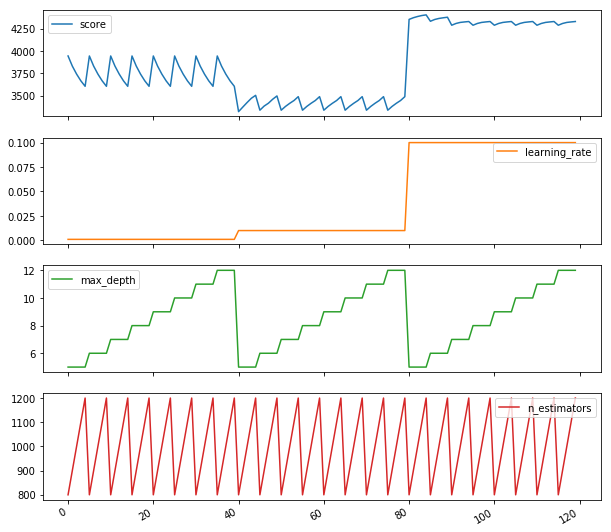

In [7]:
gs_results_df=pd.DataFrame(np.transpose([-gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

We can see that for example max_depth is the least important parameter it does not influence score significantly. But we are searching over 8 different values of max_depth, and with any fixed value search over other parameters. It is obvious waste of time and resources.

Let's try a RandomizedSearch approach now.

## Random Search

Random Search is on average more effective than Grid Search.

Main advantages:
1. Don't spend time on meaningless parameters. On every step random search variate all parameters.
2. On average finds sub optimal parameters much faster than Grid search.
3. It is not limited by grid when we optimize continuous parameters.

Disadvantages:
1. It may not find the global optimal parameter on a grid.
2. All steps are independent. On every particular step it does not use any information about the results gathered so far. But they can be useful. For example, if we found a good solution it can be useful to search around it to find even better point comparing to looking at other completely random variants.

Let's try to use RandomizedSearchCV from sklearn.model_selection.

We will start with very broad parameters space and make only 50 random steps:

In [8]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),
                'random_state': [random_state]}

rs=RandomizedSearchCV(model, param_grid_rand, n_iter = n_iter, scoring='neg_mean_squared_error', fit_params=None, 
                n_jobs=-1, cv=kf, verbose=False, random_state=random_state)

rs.fit(train_data, train_targets)

rs_test_score=mean_squared_error(test_targets, rs.predict(test_data))

print("Best MSE {:.3f} params {}".format(-rs.best_score_, rs.best_params_))

Best MSE 3200.924 params {'learning_rate': 0.0047508101621027985, 'max_depth': 19, 'n_estimators': 829, 'random_state': 42}
Wall time: 45.4 s


As we can see, the results are already better than GridSearchCV. We have spent less time and made more complete search. Let's look at our visualization:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AA8C913C8>,
      dtype=object)

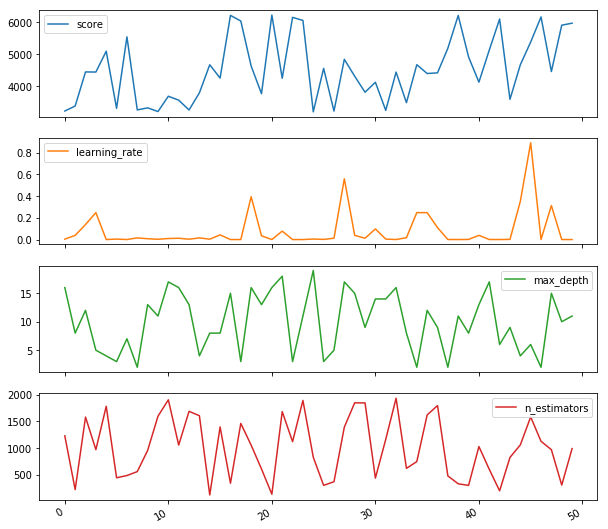

In [9]:
rs_results_df=pd.DataFrame(np.transpose([-rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

As we can see every step is completely random. It helps not to spent time on useless parameters, but it still does not use the information gathered on the first steps to improve outcomes of the latter ones.

We can modify random search adding more attention to the areas where we have already find quite a good solutions. There are different ways to do it. We will consider two of them Tree-structured Parzen Estimator and Simulated Anneal.

## Hyperopt

We will use hyperopt [https://github.com/hyperopt/hyperopt] library to deal with this algorithms. It is one of the most popular libraries for the hyperparameter optimization.

To install the library you can use either pip or conda (depending on your environment)

In [10]:
!pip install hyperopt
#!conda install -c conda-forge hyperopt

First of all let's import some useful functions from the hyperopt:
- fmin - the main function for us, it will minimize our functional
- tpe and anneal - optimization approaches
- hp - include different distributions of variables
- Trials - is used for logging

In [11]:
from hyperopt import fmin, tpe, hp, anneal, Trials

The interface of hyperop.fmin differs from Grid or Randomized search. First of all we need to create a function to minimize.

In [12]:
def gb_mse_cv(params, random_state=random_state, cv=kf, X=train_data, y=train_targets):
    # the function gest a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

We are finally prepared - we have a function gb_mse_cv(), that we will minimize varying parameters: 'learning_rate', 'max_depth', 'n_estimators'. Let's start with the TPE algorithm.

### Tree-structured Parzen Estimator

TPE is a default algorithm for the Hyperopt. It uses Bayesian approach for optimization. At every step it is trying to build probabilistic model of the function and choose the most promising parameters for the next step. Generally this types of algorithms works like this:

1. Generate random initial point ${x^*}$
2. Calculate ${F(x^*)}$
3. Using the history of trials try to build the conditional probability model $P(F | x)$
4. Choose ${x_i}$ that according to the $P(F | x)$ will most probably result in better ${F(x_i)}$
5. Compute the real value of the ${F(x_i)}$
6. Repeat steps 3-5 until one of the stop criteria is satisfied, for example i > max_eval

More information about particular TPE algorithm you can find, for example, here [https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f] or in other articles. But it is beyond the scope of this tutorial.

Let's go to practice.

Using of fmin is very simple. We just need to define the possible space of our parameters and call the function.

In [13]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()


best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(train_data,train_targets)
tpe_test_score=mean_squared_error(test_targets, model.predict(test_data))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

Best MSE 3186.791 params {'learning_rate': 0.026975706032324936, 'max_depth': 20.0, 'n_estimators': 168.0}
Wall time: 3min


We have managed to find even better solution comparing to the RandomizedSearch.
Let's look at the visualization of the process

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AA94D6DD8>,
      dtype=object)

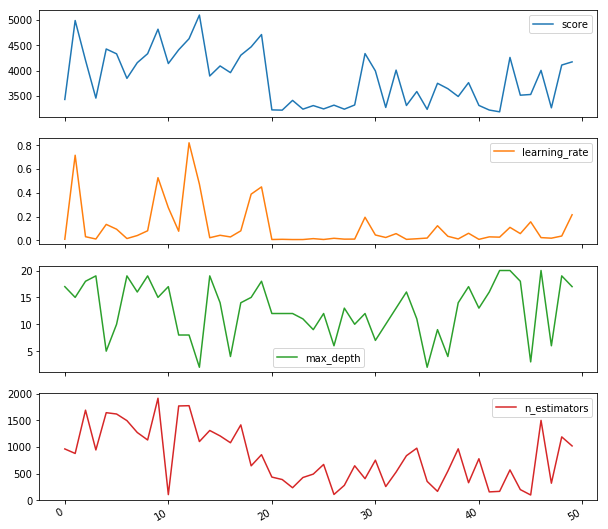

In [14]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

We can see that the movement of the parameters are quite random but the results become better with time: there are no extremely bad scores after 25 iterations but the number of good solutions increases. Algorithm started to predict quite good solutions, using information from the previous steps.

### Simulated Anneal

Simulated anneal minimizes function ${F(x)}$ (in case of hyperparameters optimization x - parameters, F() - cross validation score function) as follows:

1. Generate random initial point ${x^*}$
2. Calculate ${F(x^*)}$

3. Generate ${x_i}$ randomly in some neighbourhood of ${x*}$
4. Calculate ${F(x_i)}$
5. Update ${x*}$ according to the rule:

    if ${F(x_i)}<={F(x^*)}: {x^*} = {x_i}$ 

    else: ${x^*} = {x_i}$ with probability $p=\exp\left(\dfrac{F({x^*})-F({x_i})}{T_i}\right)$

where ${T_i}$, called temperature is constantly decreasing sequence

Repeat steps 3-5 until one of the stop criteria is satisfied:
- i > max_eval
- ${T_i} < {T_{min}}$

While ${T_i}$ is high, the algorithm performs a lot of exploration steps (similar to random search) as the probability to update ${x^*}$ is high even if ${F(x_i)}>{F(x^*)}$

But when T became lower the algorithm focuses on exploitation - all ${x_i}$ are near one of the best solutions found so far.

In the end with the right algorithms parameters it can reach a good balance between exploitation / exploration and can lead to the better results comparing to the Random Search. Let's check it on our toy example.

You can try to implement your own realization of the simulated annealing algorithm (it is much easier than TPE), but it is already implemented in hyperopt and we can just set "algo" param of fmin to "anneal.suggest" (hyperopt will automatically chose parameters of anneal for you).

In [15]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()


best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(train_data,train_targets)
sa_test_score=mean_squared_error(test_targets, model.predict(test_data))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

Best MSE 3204.336 params {'learning_rate': 0.006780152596902742, 'max_depth': 5.0, 'n_estimators': 619.0}
Wall time: 2min 50s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AA966D278>,
      dtype=object)

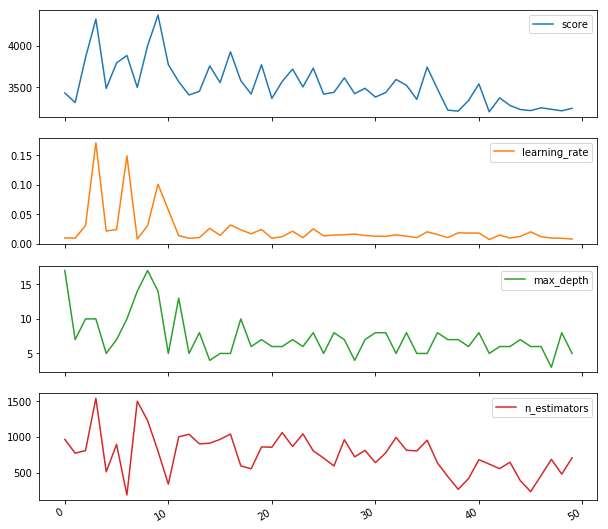

In [16]:
sa_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

sa_results_df=pd.DataFrame(sa_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
sa_results_df.plot(subplots=True,figsize=(10, 10))

This visualization shows the main idea of the Simulated annealing algorithm very well. At the beginning when the temperature is high it works similarly to Random Search - it is just exploring all possible states. But along with cooling it moves to exploitation stage and focus on the most promising areas. And finally converges to the very good solution.

## Results

Let's plot best_cumulative_score vs. number_of_iterations for all approaches:

Text(0,0.5,'best_cumulative_score')

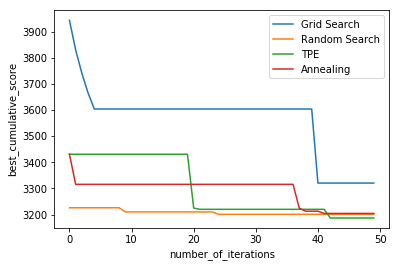

In [17]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()
scores_df['TPE']=tpe_results_df['score'].cummin()
scores_df['Annealing']=sa_results_df['score'].cummin()

ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

We can see than TPE and Annealing algorithms actually keeps improving search results over time even on later steps while Random search randomly found quite a good solution in the beginning and then only slightly improved the results. The current difference between TPE and RandomizedSearch results is quite small but in some real life applications with more diversified range of hyperparameters hyperopt can give you significant time/score improvement.

Note: in real life it is more correct to use time and not a number of iterations for comparison, but in our toy example the proportion of time spent on the additional calculations in tpe and annealing is to high comparing to cross_val_score calculation time so I have decided not to mislead you about computational speed of the hyperopt and plot scores in relation to the iteration number.

And just to be sure that everything was correct let's compare test data results, and ensure they are inline with cross validation ones

In [18]:
print('Test MSE scored:')
print("Grid Search {:.3f}".format(gs_test_score))
print("Random Search {:.3f}".format(rs_test_score))
print("TPE {:.3f}".format(tpe_test_score))
print("Annealing {:.3f}".format(sa_test_score))

Test MSE scored:
Grid Search 3045.329
Random Search 2877.117
TPE 2942.574
Annealing 2792.322


It is turned out that the results from the Annealing algorithm actually has the lowest test score. The results shake and on average better test score comparing to the CV are the consequences of the very small dataset.

## Resume

Now you know more about different hyperparameters optimization approaches and can apply hyperopt library on practice. In real case you never know in advance which approach will be the best (even in this toy example with some random states RandomizedSearch can win), and sometimes fast GridSearch or simple RandomizedSearch can be a good choice, but it is always useful to know about alternatives.

Hope this tutorial will save you a lot of time in the future ML projects.

## Bonus

Actually hypeopt has wrappers for the most popular sklearn functions. Using them you don't even need to specify the space of parameters you need just tell hyperopt, what function you want to use. Just look at example below (we will use  XGBoost as an example because there is no LGBMRegressor in hpsklearn).

In [19]:
# installing hpsklearn
!pip install hpsklearn

In [20]:
%%time

from hpsklearn import HyperoptEstimator, xgboost_regression

estim = HyperoptEstimator(regressor=xgboost_regression('my_gb'), max_evals=n_iter, trial_timeout=60, seed=random_state)

estim.fit(train_data, train_targets)

print(mean_squared_error(test_targets, estim.predict(test_data)))

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
2972.3016807617414
Wall time: 4min 17s


We have done almost nothing but got quite a good result. Moreover, if you are lazy enough you don't even need to choose the model hyperopt will select it for you. Just ask hyperopt to find the best estimator for the given data (don't pass "regressor" parameter to the HyperoptEstimator) and wait - you can try to do it by yourself. Welcome to the AutoML world :)